In [0]:
import tensorflow as tf
from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler as Scaler
import itertools
from collections import deque

# Joint Supervision

## Definición de métricas

In [0]:
def PICP(y_lower, y_upper, y_real):
    y_lower, y_upper, y_real = np.array(y_lower), np.array(y_upper), np.array(y_real)
    return np.mean(np.greater_equal(y_real, y_lower) * np.greater_equal(y_upper, y_real))

def PINAW(y_lower, y_upper, y_real):
    y_lower, y_upper, y_real = np.array(y_lower), np.array(y_upper), np.array(y_real)
    return (1 / (max(y_real) - min(y_real))) * np.mean(y_upper - y_lower)

## Procesamiento de datos

In [0]:
def process_data(y_data, y_regressors, u_data, u_regressors, steps=1, u_scaler=None, y_scaler=None):

    y_data = np.array(y_data).reshape(-1, 1)
    y_scaler = y_scaler or Scaler().fit(y_data)
    y_data = y_scaler.transform(y_data)

    y_data = y_data.reshape(-1)

    u_scaler = None
    if len(u_data) > 0:
        u_data = np.array(u_data).reshape(-1, 1)
        u_scaler = u_scaler or Scaler().fit(u_data)
        u_data = u_scaler.transform(u_data)
        u_data = u_data.reshape(-1)

    zipped_data = list(itertools.zip_longest(u_data, y_data))

    biggest_u_regressor = max(u_regressors or [-np.inf])
    biggest_y_regressor = max(y_regressors)
    biggest_regressor = max(biggest_y_regressor, biggest_u_regressor)

    x_train, y_train = [], []
    x_val, y_val = [], []

    # X = [u(k - reg1), ..., u(k - regn), y(k - regy1), ..., y(k - regym)]
    for i, (u, y) in enumerate(zipped_data[biggest_regressor + steps - 1:], biggest_regressor + steps - 1):
        u_regs = [val for j, (val, _) in enumerate(reversed(zipped_data[:i - steps + 1]), 1) if j in u_regressors]
        y_regs = [val for j, (_, val) in enumerate(reversed(zipped_data[:i - steps + 1]), 1) if j in y_regressors]
        x_train.append([*u_regs, *y_regs])
        y_train.append([y])

    return (np.array(x_train), np.array(y_train)), (u_data, y_data), (u_scaler, y_scaler)

## Implementación Joint Supervision

In [0]:
def joint_supervision_loss(lda, loss_type):

    def upper_loss_wrapper(y_true, y_pred):
        e_upper = y_true - y_pred
        L_supper = tf.keras.backend.mean(tf.square(e_upper))
        L_iupper = tf.keras.backend.mean(tf.square(e_upper) * tf.cast(e_upper > 0, tf.float32))

        return L_supper + lda * L_iupper

    def lower_loss_wrapper(y_true, y_pred):
        e_lower = y_true - y_pred
        L_slower = tf.keras.backend.mean(tf.square(e_lower))
        L_ilower = tf.keras.backend.mean(tf.square(e_lower) * tf.cast(e_lower < 0, tf.float32))

        return L_slower + lda * L_ilower

    def crisp_loss_wrapper(y_true, y_pred):
        e_crisp = y_true - y_pred
        L_scrisp = tf.keras.backend.mean(tf.square(e_crisp))

        return L_scrisp

    if loss_type == 'upper':
        return upper_loss_wrapper
    
    elif loss_type == 'lower':
        return lower_loss_wrapper
    
    elif loss_type == 'crisp':
        return crisp_loss_wrapper

    else:
        raise ValueError("Wrong loss_type")

In [0]:
class JointSupNet:
    def __init__(self, lda, nhidden, u_reg, y_reg, first_way=True, load_net=None):
        self.first_way = first_way
        self.u_reg = u_reg
        self.y_reg = y_reg

        ishape = len(u_reg) + len(y_reg)

        if load_net is None:
            if self.first_way:
                self.net_crisp = tf.keras.Sequential([
                    tf.keras.layers.Dense(nhidden, activation='tanh', input_shape=(ishape,)),
                    tf.keras.layers.Dense(1)
                ])

                self.net_upper = tf.keras.Sequential([
                    tf.keras.layers.Dense(nhidden, activation='tanh', input_shape=(ishape,), trainable=False),
                    tf.keras.layers.Dense(1)
                ])

                self.net_lower = tf.keras.Sequential([
                    tf.keras.layers.Dense(nhidden, activation='tanh', input_shape=(ishape,), trainable=False),
                    tf.keras.layers.Dense(1)
                ])

                opt1 = tf.keras.optimizers.Adam(1e-3)
                self.net_crisp.compile(loss=joint_supervision_loss(lda, 'crisp'), optimizer=opt1)
                opt2 = tf.keras.optimizers.Adam(1e-3)
                self.net_lower.compile(loss=joint_supervision_loss(lda, 'lower'), optimizer=opt2)
                opt3 = tf.keras.optimizers.Adam(1e-3)
                self.net_upper.compile(loss=joint_supervision_loss(lda, 'upper'), optimizer=opt3)

            else:
                x = tf.keras.layers.Input((ishape,))
                hidd = tf.keras.layers.Dense(nhidden, activation='relu')(x)
                lower = tf.keras.layers.Dense(1, name='lower')(hidd)
                upper = tf.keras.layers.Dense(1, name='upper')(hidd)
                crisp = tf.keras.layers.Dense(1, name='crisp')(hidd)

                opt = tf.keras.optimizers.Adam(1e-3)
                self.model = tf.keras.Model(x, [lower, crisp, upper])
                self.model.compile(loss=[
                    joint_supervision_loss(lda, 'lower'),
                    joint_supervision_loss(lda, 'crisp'),
                    joint_supervision_loss(lda, 'upper')
                    ],
                    optimizer=opt)
        
        else:
            self.model = tf.keras.models.load_model(load_net + '.h5', compile=False)

    def fit(self, *args, **kwargs):
        if self.first_way:
            self.net_crisp.fit(*args, **kwargs)

            weights = self.net_crisp.get_layer(index=0).get_weights()
            self.net_lower.get_layer(index=0).set_weights(weights)
            self.net_upper.get_layer(index=0).set_weights(weights)

            self.net_lower.fit(*args, **kwargs)
            self.net_upper.fit(*args, **kwargs)
        
        else:
            self.model.fit(*args, **kwargs)

    def predict_steps(self, x, u=[], steps=1):
        if self.first_way:
            return self.net_lower.predict(x), self.net_crisp.predict(x), self.net_upper.predict(x)
        
        else:
            if steps == 1:
                return self.model.predict(x)

            x = x[:-steps + 1, :]

            u_data = x[:, :len(self.u_reg)]
            y_data = x[:, len(self.u_reg):]
            assert(u_data.shape == (x.shape[0], len(self.u_reg)) and y_data.shape == (x.shape[0], len(self.y_reg)))

            for step in range(steps):
                x_to_pred = np.hstack([u_data, y_data])
                prediction = self.model.predict(x_to_pred)

                # Update vectors
                y_data = np.hstack([y_data[:, 1:], np.array(prediction[1]).reshape(-1, 1)])
                if len(u) > 0:
                    u_data = np.hstack([u_data[:, 1:], np.array(u[len(self.u_reg) + step: len(self.u_reg) + step + x.shape[0]]).reshape(-1, 1)])

            return prediction

    def save(self, name):
        if self.first_way:
            self.net_lower.save('lower' + name)
            self.net_upper.save('upper' + name)
            self.net_crisp.save('crisp' + name)
        
        else:
            self.model.save(name)

In [0]:
def train(y_train, y_val, y_regressors, u_train, u_val, u_regressors, nhidden, lda, batch_size, epochs, steps=1):
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

    (x_train_proc, y_train_proc), (u_traindata_norm, y_traindata_norm), (u_scaler, y_scaler) = process_data(y_train, y_regressors, u_train, u_regressors, steps)
    (x_val_proc, y_val_proc), (u_valdata_norm, y_valdata_norm), (_, _) = process_data(y_val, y_regressors, u_val, u_regressors, steps, u_scaler=u_scaler, y_scaler=y_scaler)

    net_model = JointSupNet(lda, nhidden, u_regressors, y_regressors, first_way=False)
    net_model.fit(x_train_proc, y_train_proc, validation_data=(x_val_proc, y_val_proc), batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)

    data = {
        'u_valdata_norm': u_valdata_norm,
        'u_regressors': u_regressors,
        'y_regressors': y_regressors,
        'u_val': u_val,
        'y_val': y_val,
        'x_val_proc': x_val_proc,
        'y_val_proc': y_val_proc,
        'x_train_proc': x_train_proc,
        'y_train_proc': y_train_proc,
        'y_scaler': y_scaler,
        'u_scaler': u_scaler
    }

    return net_model, data

In [0]:
def plot_interval(net_model, data, steps, prediction_type, title=None, max_index=None):

    if prediction_type == 'one_step':
        train_steps = 1
        pred_steps = steps

    elif prediction_type == 'train_step':
        train_steps = steps
        pred_steps = 1
    
    else:
        raise ValueError("prediction_type must be either one_step or train_step")

    lower, crisp, upper = net_model.predict_steps(data['x_val_proc'], data.get('u_valdata_norm', []), pred_steps)
    y_val_proc = data['y_val_proc'][pred_steps - 1:]

    fig, ax = plt.subplots(figsize=(15, 8))

    desclower = data['y_scaler'].inverse_transform(lower).reshape(-1)
    descupper = data['y_scaler'].inverse_transform(upper).reshape(-1)
    descval = data['y_scaler'].inverse_transform(y_val_proc).reshape(-1)

    print(f"PICP: {PICP(desclower, descupper, descval)}, PINAW: {PINAW(desclower, descupper, descval)}")

    if max_index:
        desclower = desclower[:max_index]
        descupper = descupper[:max_index]
        descval = descval[:max_index]

    ax.fill_between(list(range(len(desclower))), desclower, descupper, alpha=0.5, label='intervalo', color='gray')
    ax.plot(desclower, color='black', linewidth=0.7)
    ax.plot(descupper, color='black', linewidth=0.7)
    ax.plot(descval, 'o', label='validación', color='blue')

    ax.set_xlabel('t', fontsize=20)
    ax.set_ylabel('y(t)', fontsize=20)
    letter = '' if steps == 1 else 's'
    ax.set_title(title or f'Predicción a {steps} paso{letter}, intervalo Joint Supervision', fontsize=20)

    ax.legend()

In [0]:
def joint_supervision_algorithm(
    y_train,
    y_val,
    y_regressors,
    u_train=None,
    u_val=None,
    u_regressors=[],
    steps=1,
    nhidden=20,
    wanted_picp=0.9,
    batch_size=200,
    epochs=100,
    starting_lambda=1,
    delta_lambda=5,
    picptrains=4,
    ntrains=5,
    save_net=None,
    prediction_type='one_step'):

    if prediction_type == 'one_step':
        train_steps = 1
        pred_steps = steps

    elif prediction_type == 'train_step':
        train_steps = steps
        pred_steps = 1
    
    else:
        raise ValueError("prediction_type must be either one_step or train_step")

    print("Starting Joint Supervision Algorithm...")

    lda = starting_lambda - delta_lambda

    picp = 0
    best = (np.inf, None)

    picps = []
    mean_picp = 0
    print("\tFinding best lambda")
    while mean_picp < wanted_picp:
        lda += delta_lambda
        print(f"\t\tTraining networks with lambda = {lda}")
        for _ in range(picptrains):
            net_model, data = train(y_train, y_val, y_regressors, u_train, u_val, u_regressors, nhidden, lda, batch_size, epochs, train_steps)
            
            lower, crisp, upper = net_model.predict_steps(data['x_val_proc'], data['u_valdata_norm'], pred_steps)
            picp = PICP(lower, upper, data['y_val_proc'][pred_steps - 1:])
            picps.append(picp)

        mean_picp = np.mean(picps)
        print(f"\t\tObtained mean PICP = {mean_picp}")

    print(f"\tFound lambda = {lda}")

    print(f"\tTraining multiple networks with lambda = {lda}")
    for i in range(ntrains):
        print(f"\t\tTraining network {i}")
        net_model, data = train(y_train, y_val, y_regressors, u_train, u_val, u_regressors, nhidden, lda, batch_size, epochs, train_steps)

        lower, crisp, upper = net_model.predict_steps(data['x_val_proc'], data['u_valdata_norm'], pred_steps)

        lower = data['y_scaler'].inverse_transform(lower).reshape(-1)
        upper = data['y_scaler'].inverse_transform(upper).reshape(-1)
        val = data['y_scaler'].inverse_transform(data['y_val_proc'][pred_steps - 1:]).reshape(-1)

        pinaw = PINAW(lower, upper, val)
        best = (pinaw, net_model, data) if pinaw < best[0] else best
        print(f"\t\tBest PINAW = {best[0]}")

    best_model = best[1]
    best_data = best[2]

    if save_net: best_model.save(save_net + '.h5')

    return best_model, best_data

## Pruebas

In [0]:
datos = loadmat('uy.mat')
u, y = datos['u'], datos['y'][0]
itr = 55 * 6000 // 100
ite = 80 * 6000 // 100

y_train, y_test, y_val = y[:itr].reshape(-1), y[itr:ite].reshape(-1), y[ite:].reshape(-1)
u_train, u_test, u_val = u[:itr].reshape(-1), u[itr:ite].reshape(-1), u[ite:].reshape(-1)

In [0]:
nhidden = 20
lda = 200
batch_size = 200
epochs = 1

y_regressors = list(range(1, 6))
u_regressors = list(range(1, 6))

(x_train_proc, y_train_proc), (u_scaler, y_scaler) = process_data(y_train, y_regressors, u_train, u_regressors)
(x_val_proc, y_val_proc), (_, _) = process_data(y_val, y_regressors, u_val, u_regressors, u_scaler=u_scaler, y_scaler=y_scaler)

net_model = JointSupNet(lda, nhidden, u_regressors, y_regressors, first_way=False, load_net='p1_net')
lower, crisp, upper = net_model.predict_steps(x_val_proc, u_val, steps=16)

PICP: 0.80836820083682, PINAW: 0.2832349986604516


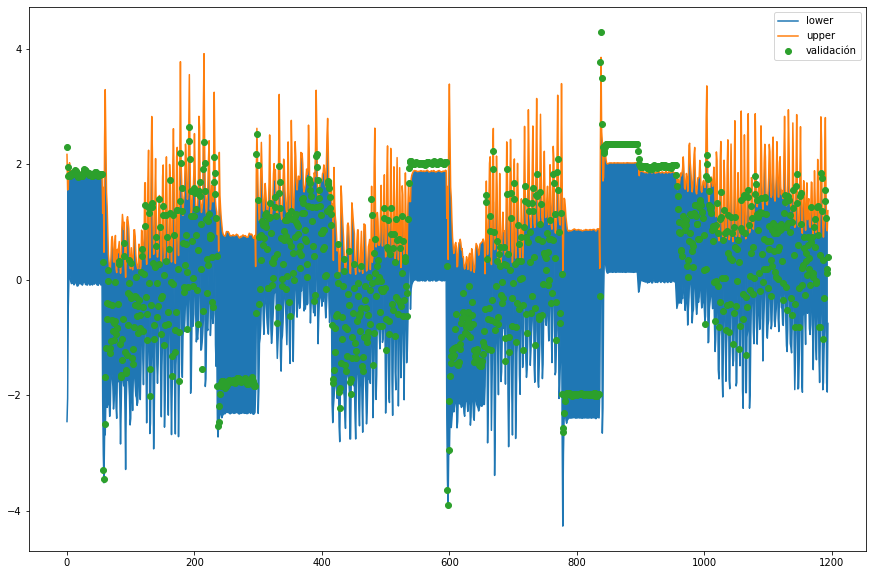

In [134]:
plot_interval(net_model, {'y_val_proc': y_val_proc, 'y_scaler': y_scaler, 'x_val_proc': x_val_proc, 'u_val': u_val}, 1, max_index=None)

## Pregunta 1, parte f)

### Carga de datos

In [0]:
datos = loadmat('uy.mat')
u, y = datos['u'], datos['y'][0]
itr = 55 * 6000 // 100
ite = 80 * 6000 // 100

y_train, y_test, y_val = y[:itr].reshape(-1), y[itr:ite].reshape(-1), y[ite:].reshape(-1)
u_train, u_test, u_val = u[:itr].reshape(-1), u[itr:ite].reshape(-1), u[ite:].reshape(-1)

### Entrenamiento 1 paso

In [0]:
nhidden = 20
batch_size = 200
epochs = 100
wanted_picp = 0.9
steps = 1

u_regressors = list(range(1, 6))
y_regressors = list(range(1, 6))

best_model_1, best_data_1 = joint_supervision_algorithm(
    y_train,
    y_val,
    y_regressors,
    u_train,
    u_val,
    u_regressors,
    steps,
    nhidden,
    wanted_picp,
    batch_size,
    epochs,
    starting_lambda=500,
    delta_lambda=10,
    save_net='p1_net_1_paso',
    prediction_type='one_step'
)

PICP: 0.9589958158995816, PINAW: 0.23088709958720527


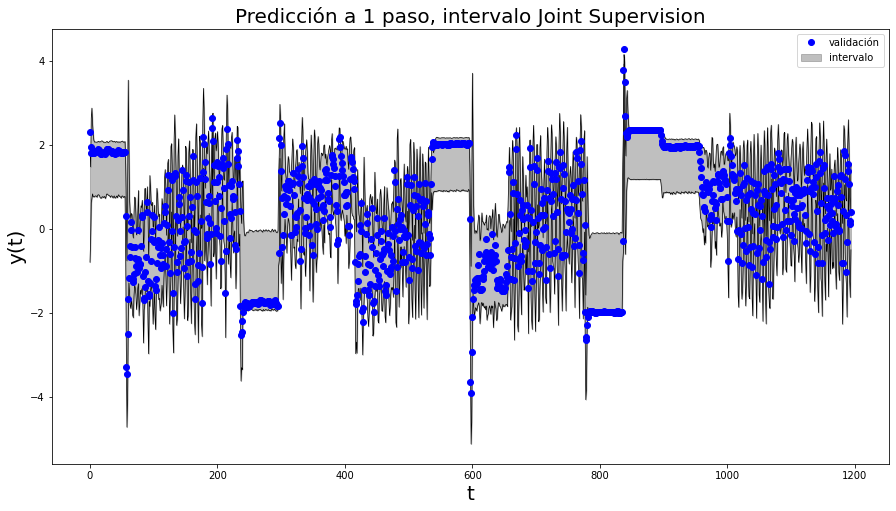

In [349]:
plot_interval(best_model_1, best_data_1, steps, prediction_type='one_step')

### Entrenamiento 8 pasos

In [0]:
nhidden = 20
batch_size = 200
epochs = 100
wanted_picp = 0.1
steps = 8

u_regressors = list(range(1, 6))
y_regressors = list(range(1, 6))

best_model_8, best_data_8 = joint_supervision_algorithm(
    y_train,
    y_val,
    y_regressors,
    u_train,
    u_val,
    u_regressors,
    steps,
    nhidden,
    wanted_picp,
    batch_size,
    epochs,
    starting_lambda=5000,
    delta_lambda=1000,
    save_net='p1_net_8_pasos',
    prediction_type='one_step'
)

PICP: 0.9022746419545071, PINAW: 0.47989453461545994


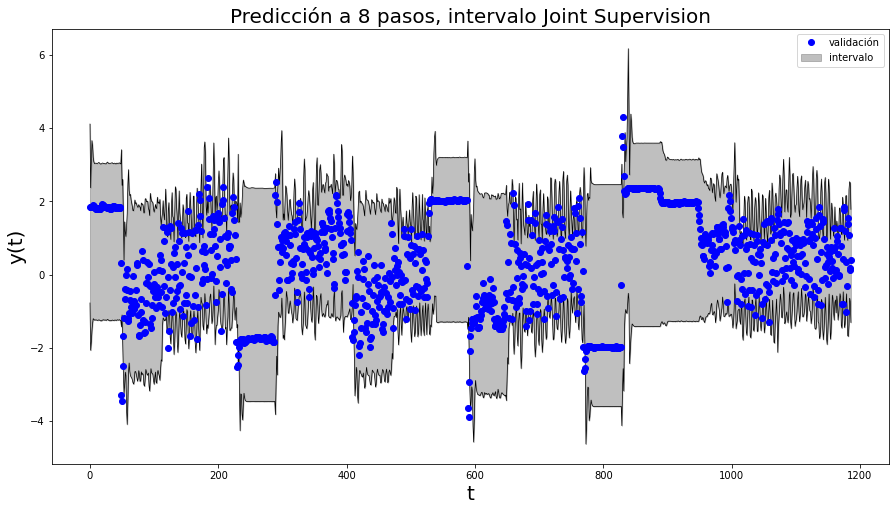

In [280]:
plot_interval(best_model_8, best_data_8, steps=8, prediction_type='one_step')

### Entrenamiento 16 pasos

In [223]:
nhidden = 20
batch_size = 200
epochs = 100
wanted_picp = 0.9
steps = 16

u_regressors = list(range(1, 6))
y_regressors = list(range(1, 6))

best_model_16, best_data_16 = joint_supervision_algorithm(
    y_train,
    y_val,
    y_regressors,
    u_train,
    u_val,
    u_regressors,
    steps,
    nhidden,
    wanted_picp,
    batch_size,
    epochs,
    starting_lambda=10000,
    delta_lambda=1000,
    save_net='p1_net_16_pasos',
    prediction_type='one_step'
)

Starting Joint Supervision Algorithm...
	Finding best lambda
		Training networks with lambda = 10000
		Obtained mean PICP = 0.9006355932203389
	Found lambda = 10000
	Training multiple networks with lambda = 10000
		Training network 0
		Best PINAW = [0.50639206]
		Training network 1
		Best PINAW = [0.50639206]
		Training network 2
		Best PINAW = [0.50639206]
		Training network 3
		Best PINAW = [0.42787005]
		Training network 4
		Best PINAW = [0.42787005]


PICP: 0.8576271186440678, PINAW: 0.42787004314205657


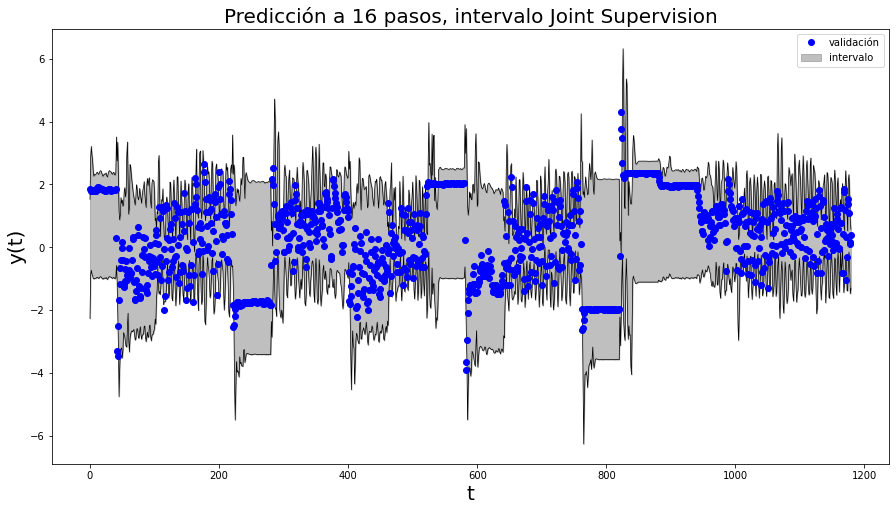

In [282]:
plot_interval(best_model_16, best_data_16, 16, prediction_type='one_step')

## Pregunta 2, parte b)

### Carga de datos

In [225]:
train_2015 = True

datos15 = loadmat('DatosPV2015.mat')
datos17 = loadmat('DatosPV2017.mat')

y15 = datos15['data2015']
y17 = datos17['data2017']

val_per = (1200 / len(y17)) * 100

if train_2015:
    iv = int((val_per * len(y17)) // 100)
    y_train_p2 = y15.reshape(-1)
    y_val_p2 = y17[:iv].reshape(-1)
    y_test_p2 = y17[iv:].reshape(-1)
    print(len(y_train_p2), len(y_val_p2), len(y_test_p2))

else:
    itr15 = 55 * len(y15) // 100
    ite15 = 80 * len(y15) // 100
    itr17 = 55 * len(y17) // 100
    ite17 = 80 * len(y17) // 100
    y_train_15, y_test_15, y_val_15 = y15[:itr15].reshape(-1), y15[itr15:ite15].reshape(-1), y15[ite15:].reshape(-1)
    y_train_17, y_test_17, y_val_17 = y17[:itr17].reshape(-1), y17[itr17:ite17].reshape(-1), y17[ite17:].reshape(-1)

2928 1200 1344


### Entrenamiento 1 paso

In [176]:
nhidden = 15
batch_size = 200
epochs = 100
wanted_picp = 0.9
steps = 1

u_train = []
u_val = []
u_regressors = []
y_regressors = list(range(1, 25))

best_model_p2_1, best_data_p2_1 = joint_supervision_algorithm(
    y_train_p2,
    y_val_p2,
    y_regressors,
    u_train,
    u_val,
    u_regressors,
    steps,
    nhidden,
    wanted_picp,
    batch_size,
    epochs,
    starting_lambda=500,
    delta_lambda=10,
    save_net='p2_net_1_paso',
    prediction_type='train_step'
)

Starting Joint Supervision Algorithm...
	Finding best lambda
		Training networks with lambda = 500
		Obtained mean PICP = 0.8926445578231292
		Training networks with lambda = 510
		Obtained mean PICP = 0.8836096938775511
		Training networks with lambda = 520
		Obtained mean PICP = 0.8925736961451247
		Training networks with lambda = 530
		Obtained mean PICP = 0.9030612244897959
	Found lambda = 530
	Training multiple networks with lambda = 530
		Training network 0
		Best PINAW = [0.73173323]
		Training network 1
		Best PINAW = [0.4932622]
		Training network 2
		Best PINAW = [0.4932622]
		Training network 3
		Best PINAW = [0.44522267]
		Training network 4
		Best PINAW = [0.44522267]


PICP: 0.8435374149659864, PINAW: 0.44522270308053685


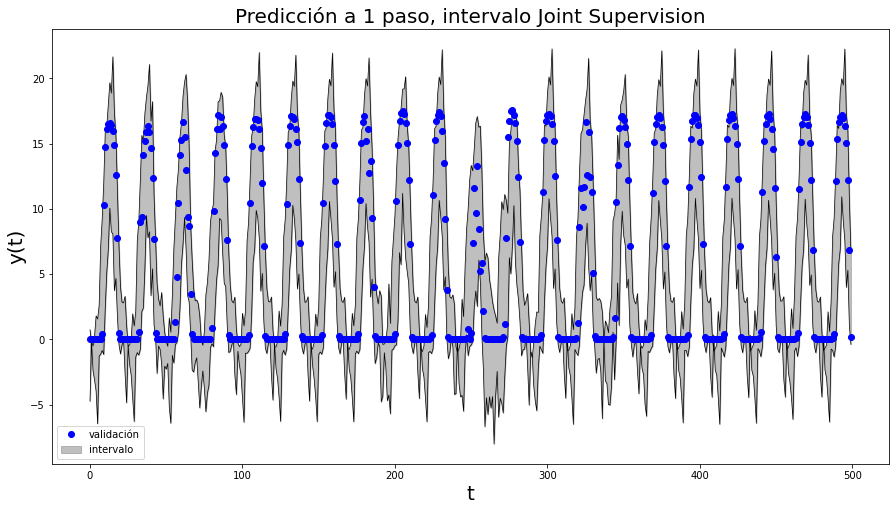

In [285]:
plot_interval(best_model_p2_1, best_data_p2_1, max_index=500, steps=1, prediction_type='one_step')

### Entrenamiento 6 pasos

In [0]:
nhidden = 15
batch_size = 200
epochs = 100
wanted_picp = 0.9
steps = 6

u_train = []
u_val = []
u_regressors = []
y_regressors = list(range(1, 25))

best_model_p2_6, best_data_p2_6 = joint_supervision_algorithm(
    y_train_p2,
    y_val_p2,
    y_regressors,
    u_train,
    u_val,
    u_regressors,
    steps,
    nhidden,
    wanted_picp,
    batch_size,
    epochs,
    starting_lambda=1000,
    delta_lambda=50,
    save_net='p2_net_6',
    prediction_type='train_step'
)

PICP: 0.9359521776259607, PINAW: 0.6054296051957184


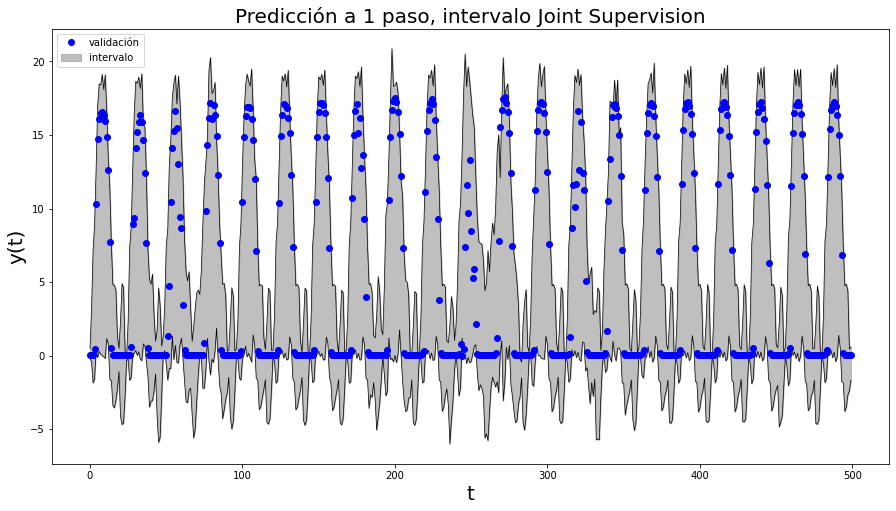

In [305]:
plot_interval(best_model_p2_6, best_data_p2_6, max_index=500, steps=1, prediction_type='one_step')

### Entrenamiento 12 pasos

In [306]:
nhidden = 15
batch_size = 200
epochs = 100
wanted_picp = 0.5
steps = 12

u_train = []
u_val = []
u_regressors = []
y_regressors = list(range(1, 25))

best_model_p2_12, best_data_p2_12 = joint_supervision_algorithm(
    y_train_p2,
    y_val_p2,
    y_regressors,
    u_train,
    u_val,
    u_regressors,
    steps,
    nhidden,
    wanted_picp,
    batch_size,
    epochs,
    starting_lambda=1000,
    delta_lambda=100,
    save_net='p2_net_12',
    prediction_type='train_step'
)

Starting Joint Supervision Algorithm...
	Finding best lambda
		Training networks with lambda = 1000
		Obtained mean PICP = 0.9206008583690987
	Found lambda = 1000
	Training multiple networks with lambda = 1000
		Training network 0
		Best PINAW = 0.9199398183137905
		Training network 1
		Best PINAW = 0.7605816994816036
		Training network 2
		Best PINAW = 0.6633815430619381
		Training network 3
		Best PINAW = 0.6633815430619381
		Training network 4
		Best PINAW = 0.6633815430619381


PICP: 0.9424892703862661, PINAW: 0.6633815430619381


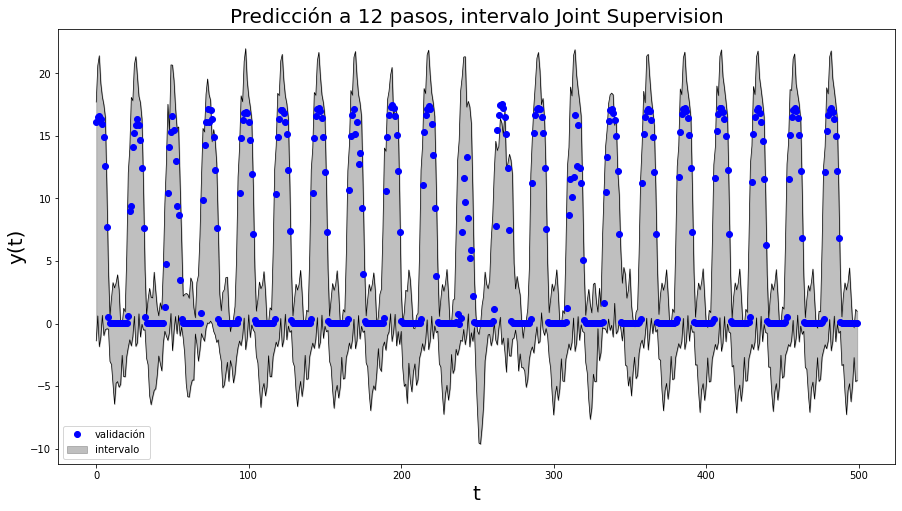

In [307]:
plot_interval(best_model_p2_12, best_data_p2_12, title='Predicción a 12 pasos, intervalo Joint Supervision', max_index=500, steps=1, prediction_type='one_step')